# 3.1 MNIST


In [58]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* 사이킷런의 데이터셋의 딕셔너리 구조  
    * 데이터 셋을 설명하는 DESCR키  
    * 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키  
    * 레이블 배열을 담은 target키  

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

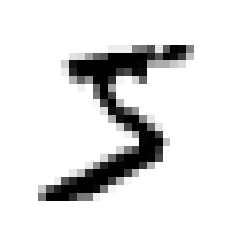

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] #X의 0행, 28*28이므로 784의 특성(열)
some_digit_image = some_digit.reshape(28, 28) #784의 열을 28 x 28로 reshape한다

plt.imshow(some_digit_image, cmap=mpl.cm.binary) #mlp라이브러리의 cm모듈의 binary
plt.axis("off") # axis를 제거한다

plt.show()

In [6]:
y[0] #실제 레이블 확인하기

'5'

---  
* 레이블은 문자열이다. 대부분의 레이블은 숫자를 기대하므로 y를 정수로 변환한다.

In [7]:
import numpy as np
y = y.astype(np.uint8)

##### MNIST 데이터셋은 이미 훈련세트(앞쪽 60,000개)와 테스트세트(뒤쪽 10,000개)로 나누어져있다.  
    * 이 데이터셋은 훈련세트를 섞어야 함. 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다.  
    * (MNIST훈련세트는 이미 섞여 있음)  
#### 어떤 알고리즘은 훈련 샘플을 섞지 않아야 하는 경우도 있다  
      * 시계열 데이터(주식, 날씨 등)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기(binary classifier)  
* 5인지 아닌지 분류하는 분류기를 만들어보자

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
#max_iter => 계산에 사용할 작업 수, default = 1000이다
#tol => 정밀도
#random_state => 난수 seed 지정
#learning rate도 설정가능하다. 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

### cross_val_score()의 주요 파라미터들,,  
    * estimator => 분류인지 회귀인지 알려줌(여기선 sgd_clf => 분류임을 알려줌)  
    * X => 데이터 세트  
    * y => 레이블 세트
    * cv => 교차 검증 폴드 수  
    * scoring => 예측 성능 평가 지표의 기준(여기선 accuracy)

### 교차 검증을 사용한 정확도 측정

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#StratifiedKFold는 class 비율을 고려해서 fold를 나눈다(계층적 샘플링을 수행)
#

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #(sgd_clf)를 복제한다 
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [14]:
#모든 이미지를 5아님 클래스로 분류
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #X의 길이의 영벡터 생성(shape -> (len(x), 1))

In [15]:
never_5_clf = Never5Classifier() #객체 생성
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#estimator = never_5_clf --> 분류 
#데이터셋(레이블X) -> X_train
#레이블 -> y_train_5

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차행렬

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#여기서도 test세트는 사용하면 안됨!! -> 테스트 셋은 프로젝트 맨 마지막에 사용!

- cross_val_predict 함수는 cross_val_score와 비슷한 인터페이스를 제공하지만  
  훈련 데이터셋의 각 샘플이 테스트 폴드가 되었을 때 만들어진 예측을 반환합니다.<br><br> 
   
- 따라서 cross_val_predict 함수의 결과를 사용하여 모델의 성능 (예를 들어 정확도)을 계산하면          cross_val_score 함수의 결과와 다르며 바람직한 일반화 성능 추정이 아닙니다. <br><br>   
- cross_val_predict()는 메서드를 지정할 수 있다.
     - method= 'predict_proba' => 예측 확률을 반환

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- 위 오차행렬의 <span style="color:red">행</span>은 <span style="color:red">실제 클래스</span>, <span style="color:blue">열</span>은 <span style="color:blue">예측 클래스</span>이다.  
- (1, 1): <span style="color:green">TN(True negative)</span>  
    - 실제로 아닌걸 아니라고 한 경우<br><br>
- (1, 2): <span style="color:green">FP(Fasle positive)</span>  
    - 실제로 아닌걸 맞다고 한 경우<br><br>
- (2, 1): <span style="color:green">FN(False negative)</span>  
    - 실제로 맞는걸 아니라고 한 경우<br><br>  
- (2, 2): <span style="color:green">TP(True positive)</span>  
    - 실제로 맞는걸 맞다고 한 경우<br><br>

In [18]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 정밀도(precision)
정밀도 = ${TP \over TP + FP}$  
- TP: 진짜 양성 수  
-  FP: 거짓 양성 수<br><br>  


### 재현율(recall)  
재현율 = ${TP \over TP + FN}$
- FN: 거짓 음성 수  
- 재현율(recall)은 민감도(sensitivity) 또는 진짜 양성 비율(true positive rate, TPR)이라고도 한다.  
- 전체 양성을 고려한다.

## 3.3.3 정밀도와 재현율

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### $F_1$ score  
- <p style="font-size:20px"> $F_1$ score = ${2 \over {1 \over 정밀도} + {1 \over 재현율}}  
      = 2 x {정밀도 x 재현율 \over 정밀도 + 재현율}  
      = {TP \over {TP +{FN + FP \over 2}}}$ </p>  
- 즉, <span style="color:blue">$F_1$ 점수는 정밀도와 재현율의 조화평균이다.</span>

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)
#정밀도와 재현율은 트레이드오프 관계에 있다. 즉 둘다 높일 수는 없음.

0.7325171197343846

## 3.3.4 정밀도/재현율 트레이드오프

In [22]:
#decision_function() -> 각 샘플의 점수를 얻을 수 있다. 여기서는 sgd_clf의 점수를 알아볼 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
#위에서 some_digit = X[0]이었음.
y_scores

array([2164.22030239])

[trade-off]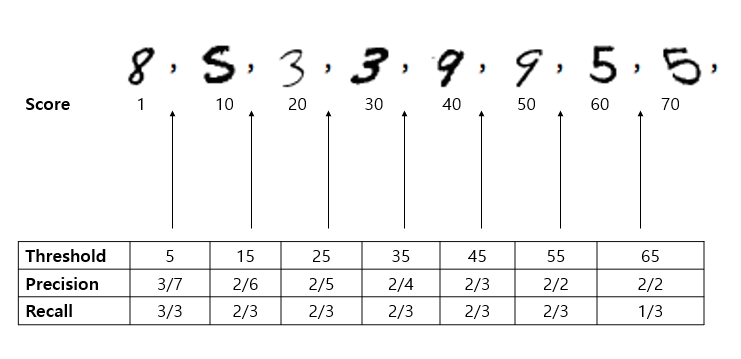

In [23]:
threshold = 0 #임계치가 0이면 predict()와 같은 결과가 나온다.
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000 #임계치를 높여보자
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#즉, 임계값을 높이면 재현율이 줄어든다.

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
#훈련 세트에 있는 모든 샘플의 점수를 구한다.

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

### 사이킷런 메트릭스의 precision_recall_curve()   
- 더 알아보기 -> [precision_recall_curve(y_true, probas_pred, *, pos_label=None, sample_weight=None)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)
    - y_true: True binary labels. 
    - probas_pred: target scores
    - pos_label: int or str로 설정. default = None. label of Positive class(양성 클래스의 레이블)  
    - sample weight: ?, defualt = None  
    - 여기선 pos_label과 sample weight가 둘 다 None으로 설정  <br><br>

- 리턴값  
    - precision, recall, threshold

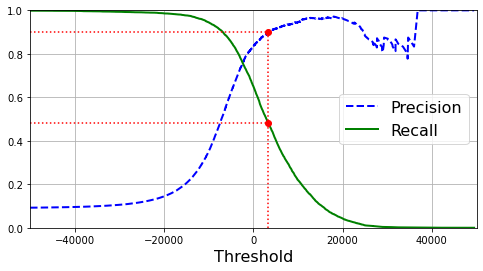

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

#정밀도와 재현율의 호출값은 각각 0~1사이 이며, 해당하는 임계값이 없다.
#즉, 그래프가 Y축에서 시작될 수 밖에 없다는 뜻이다.

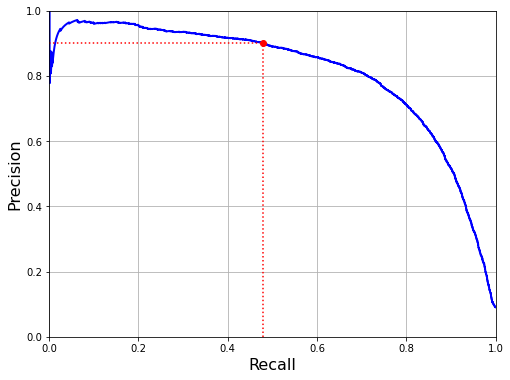

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
#save_fig("precision_vs_recall_plot")
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
#정밀도 90%이상을 목표로
#np.argmax -> 최댓값의 첫번째 인덱스 반환
threshold_90_precision

3370.0194991439594

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#### ROC곡선은 거짓 양성 비율에 대한 진짜 양성 비율이다<br><br>
$FPR = {FP \over FP+TN} = {FP + TN - TN \over FP + TN} = 1 -{TN \over FP + TN} = 1 - TNR$
- FPR은 1에서 진짜 음성 비율(TNR)을 뺀 값이다.<br>
- TNR은 특이도(specificity)라고도 한다.<br>
- TPR은 재현율의 또 다른 이름이다.<br>
- 즉, <span style="color:red">ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프이다.</span>

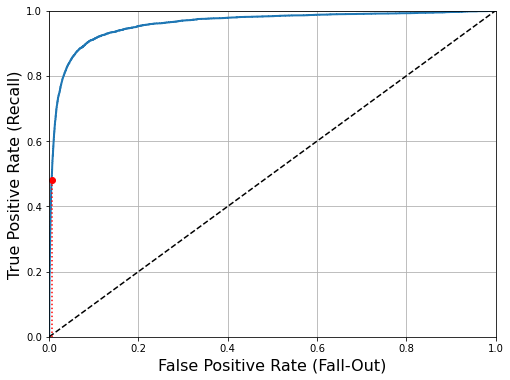

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()

- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.<br>
- 곡선 아래의 면적(area under the curve, AUC)을 측정하면 분류기들을 비교할 수 있다.<br>
    - 완벽한 분류기는 ROC의 AUC가 1<br>  
    - 완전 랜덤 분류기는 ROC의 AUC가 0.5<br>
    - 랜덤 분류기?
        - 훈련 데이터의 클래스 비율을 따라 무작위로 예측하는 것
        - 즉 ROC 곡선이, $y=x$와 비슷해진다.

In [35]:
#분류기의 AUC를 측정하는 사이킷런의 함수.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 어느 경우에 PR곡선, 어느 경우에 ROC?<br>
- 일반적인 법칙<br>
    - 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 중요할 때 -> PR 곡선<br>
    - 그 이외는 ROC곡선 사용.

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
#method -> predict_proba
#predict_proba() 메서드는 샘플이 행, 클래스가 열이고 주어진 클래스에 속할 확률을 담은
#배열을 반환한다.

In [37]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

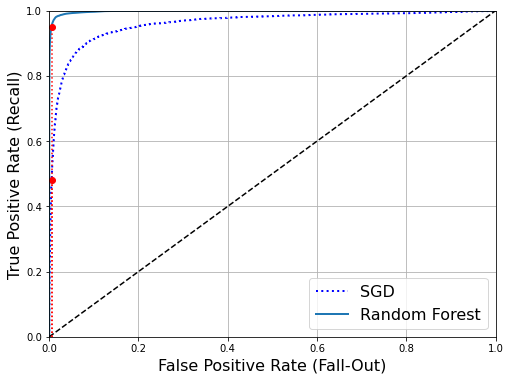

In [38]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 다중 분류

#### 다중 분류기(다항 분류기)는 둘 이상의 클래스를 구별할 수 있다.
- SGD분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등 -> 여러 개의 클래스 직접 처리 가능<br>
- 로지스틱 회귀, SVM분류기 등 -> 이진 분류만 가능.<br>
    - 하지만 이진 분류기를 여러개 사용해 다중 클래스 분류 가능
--- 
### 이진 분류기를 이용한 다중 분류 방법
#### OvR(One -versus-the-rest)
- 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9)를 훈련 시켜 클래스 10개 분류
- 분류기의 결정 점수중 가장 높은 것을 선택하여 분류.<br><br>

#### OvO(One-versus-one)
- 각 숫자의 조합마다 이진 분류기를 훈련.
- 클래스가 N개라면 분류기는 $N x (N-1) \over 2$개가 필요하다.
- 장점 -> 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 사용
---
- SVM -> 작은 훈련세트에서 많은 분류기 훈련시키는게 빠름. 따라서 OvO 선호
- 대부분의 이진 분류 알고리즘 -> OvR선호

In [40]:
#SVM 분류기(SVC) 사용
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
#0~9까지의 원래 타깃 클래스를 사용해 SVC를 훈련
#X, y 전체 다 하려니 시간이 오래 걸림 -> 1000번째 까지,,,,
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
#가장 높은 점수가 클래스 5에 해당한다.

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [42]:
np.argmax(some_digit_scores)
#최댓값의 인덱스를 출력

5

In [45]:
svm_clf.classes_
svm_clf.classes_[5]

5

In [46]:
#OvR을 사용
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
#SGD분류기는 다중 클래스 분류가 가능하기 때문에, 별도의 OvR이나 OvO적용 필요 없음

array([3], dtype=uint8)

In [49]:
#점수 확인하기
sgd_clf.decision_function([some_digit])
#가장 큰 점수가 클래스 5에 해당한다.

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
#입력 스케일을 조정하여 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #scaler객체 생성 
#fit_transform으로 변환기 적용.
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5 에러분석

- 모델의 성능을 향상시키는 방법
    1. 에러의 종류를 분석

In [52]:
#예측 만들기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

#오차 행렬 생성
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

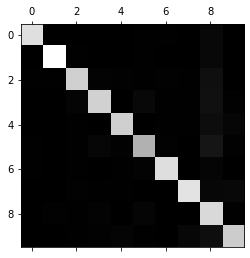

In [53]:
#오차행렬을 이미지화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 에러의 비율을 비교
    - 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 준다.<br>
    - 개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보임.

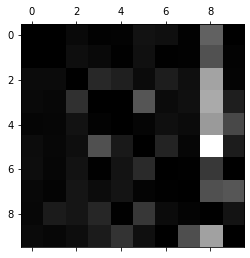

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True) #열방향대로 더해주기 = 이미지의 개수
#차원은 유지
#keepdims = True로 차원을 유지할 수 있음.

norm_conf_mx = conf_mx / row_sums
#오차행렬의 각 값을 각 클래스의 이미지 개수로 나누어준다

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### <span style="color:blue">오차 행렬 분석을 통한 insight</span>  
- 분류기의 성능 향상 방안에 대한 통찰  
    1. 오류 분석을 통해 개선해야할 점을 바로 찾을 수 있음.
    2. 각각의 에러를 분석하는 것보다 효율적이다.

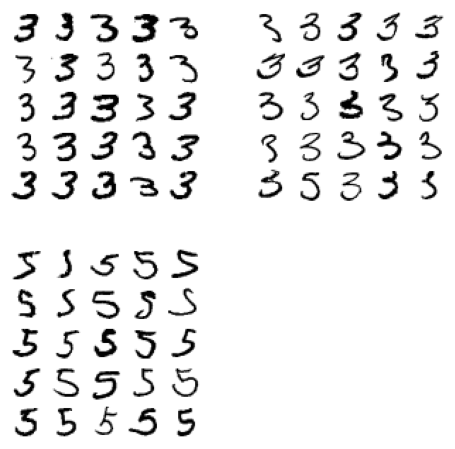

In [59]:

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.show()

- 우리 눈으로는 에러를 확인하기 쉽지만, 분류기가 실수한 이유를 이해하기는 어렵다.  
- 여기서는 SGDClassifier을 사용한 것이 원인이다.  
    - 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하기 때문이다.

# 3.6 다중 레이블 분류

#### 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 <span style="color:blue">다중 레이블 분류(multilabel classification) 시스템</span>이라고 한다.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

## K-neighbor Classifier(KNN) :추가
- 지도학습 알고리즘 중 하나이다.<br><br>
- 어떤 데이터가 주어지면 그 이웃의 데이터를 살펴본 뒤 더 많은 데이터가 포함되어 있는 범주로 분류하는 방식이다.<br><br>
- 일반적으로 K는 홀수를 사용한다.(짝수면 동점이 될 수도 있음!)<br><br>
- 훈련이 따로 필요 없고, 훈련 데이터를 저장하는게 훈련의 끝이다.<br><br>
    - 따라서 SVM이나 선형회귀보다 빠른 분류가 가능하다.
    
### 사이킷런 KNeighborsClassifier의 파라미터들
1. n_neighobrs(default=5): 분류 시 고려할 인접 샘플 수 -> kNN에서 k를 말한다.<br><br>
2. weights(default='uniform') -> 가중치. ex) distance: 가까울수록 큰 가중치 부여<br><br>
3. metric(defualt='minkowski'): 거리 계산 방법 ex)minkowski, 유클리드, 맨해튼 등)<br>  
    - 민코프스키(minkowski)는 유클리드와 맨해튼거리를 일반화 한 것이다.  
    - $D(X, Y) = (\sum_{i=1}^n|x_i - y_i|^p)^{1 \over p}$  
        - P = 1 일때 맨해튼(L1), P = 2 일 때 유클리드(L2)

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [62]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

- 위 코드는 모든 레이블의 가중치가 같다고 가정한 것이다.(객체생성시 weight 파라미터를 default로 설정)<br><br>
- 지지도  
    - 타겟 레이블에 속한 샘플 수를 의미  
- 지지도를 가중치로 주는 방법이 있다  
<br>
- average="macro" -> 모든 클래스의 FP, FN, TP 총합을 이용해 $F_1$점수를 계산.

# 3.7 다중 출력 분류

- 다중 출력 다중 클래스 분류(다중 출력 분류, multioutput classification)  
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화  
    - 즉, 한 레이블이 2개 이상의 값을 가질 수 있다.

In [63]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

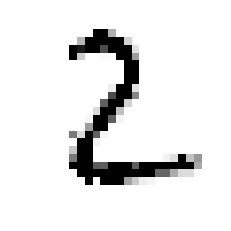

In [66]:
some_index = 1
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)